# SageMaker Pipelines - Invoking multi-tenant endpoint (SaaS)

This notebook demonstrates invoking a each tenant's model hosted on a SageMaker multi-model endpoint.

We will create a SageMaker mult-model endpoint that points to the S3 location of where  the model aritfacts were output by the SageMaker Pipeline(s).

This notebook has been tested on SageMaker Studio using the `Data Science` kernel on an `ml.t3.medium`. 


Please make sure your execution role attached to your Studio user profile has `iam:CreatePolicy, iam:CreateRole, iam:AttachRolePolicy and SageMakerFullAccess` permissions/policy attached.

---

##  Create multi-model endpoint (MME)

### Set up

Below we will retrieve the the `image_uri` we will use to host the models with. We will be using the SageMaker Triton image. We will also set the S3 location where the tenant's model are saved so that the SageMaker MME can access them. 

In [2]:
import boto3
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}

region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"

triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:23.03-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)
triton_image_uri

'785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:23.03-py3'

In [3]:
import sagemaker
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
mme_location = f"s3://{default_bucket}/model_artifacts_mme/"

print(f"Tenant's models located at: {mme_location}")

Tenant's models located at: s3://sagemaker-us-east-1-130992530969/model_artifacts_mme/


### Create SageMaker Model entity

In [4]:
import time
from sagemaker import get_execution_role
sess = boto3.Session()
sm = sess.client("sagemaker")
role = get_execution_role()


sm_model_name = f"triton-xgb-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": triton_image_uri,
    "ModelDataUrl": mme_location,
    "Mode": "MultiModel",
    "Environment": {
        "SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "fil",
        #"SAGEMAKER_TRITON_LOG_VERBOSE": "true", #"200",
        #"SAGEMAKER_TRITON_SHM_DEFAULT_BYTE_SIZE" : "20000000", #"1677721600", #"16777216000", "16777216"
        #"SAGEMAKER_TRITON_SHM_GROWTH_BYTE_SIZE": "1048576"

    }
}

create_model_response = sm.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:130992530969:model/triton-xgb-2023-05-03-04-02-16


### Create SageMaker Endpoint Configuration

In [5]:
endpoint_config_name = f"triton-xgb-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:130992530969:endpoint-config/triton-xgb-2023-05-03-04-02-21


In [6]:
endpoint_name = f"triton-xgb-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:130992530969:endpoint/triton-xgb-2023-05-03-04-02-23


In [8]:
waiter = sm.get_waiter("endpoint_in_service")
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

print("Arn: " + resp["EndpointArn"])

Waiting for endpoint to create...
Endpoint Status: InService
Arn: arn:aws:sagemaker:us-east-1:130992530969:endpoint/triton-xgb-2023-05-03-04-02-23


### Create ABAC role for invocation (Pool approach)
In this section we create an IAM role which only allows to invocatipon to a tenant specific model.

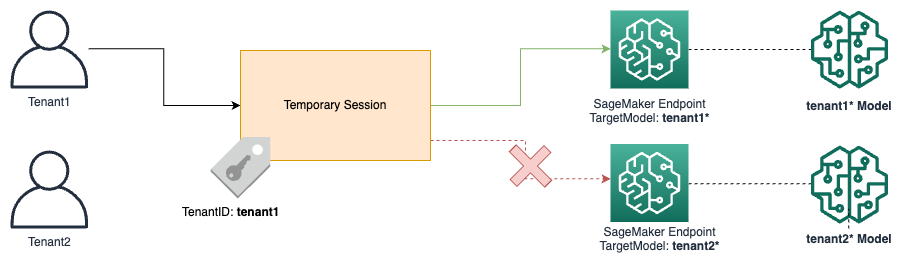

In [11]:
import boto3
import json
import sagemaker.session

sts = boto3.client('sts')
iam = boto3.client('iam')
region = boto3.session.Session().region_name
account_id = sts.get_caller_identity()['Account']

sagemaker_exec_role=sagemaker.session.get_execution_role().split('/')[-1]

invoke_policy_name="DemoTenantPipelineMMEInvokePolicy"

invoke_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "sagemaker:InvokeEndpoint",
            "Resource": "*",
            "Condition": {
                "StringLike": {
                    "sagemaker:TargetModel": "${aws:PrincipalTag/TenantID}*.tar.gz"
                }
            }
        }
    ]
}

try:
    invoke_policy = iam.create_policy(
        PolicyName=invoke_policy_name,
        PolicyDocument=json.dumps(invoke_policy_document)
    )
    
except iam.exceptions.EntityAlreadyExistsException:
    # If the policy already exists, get its ARN
    policy = iam.get_policy(PolicyArn=f"arn:aws:iam::{account_id}:policy/{invoke_policy_name}")

    # Print the ARN of the existing IAM policy
    print(f"The IAM policy {invoke_policy_name} already exists with ARN {policy['Policy']['Arn']}")

inovke_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": f"arn:aws:sts::{account_id}:assumed-role/{sagemaker_exec_role}/SageMaker"
            },
            "Action": ["sts:AssumeRole","sts:TagSession"],
            "Condition": {
                "StringLike": {
                    "aws:RequestTag/TenantID": "*"
                }
            }
        }
    ]
}


try:
    invoke_role_name = "DemoTenantPipelineMMEInvokeRole"
    role=iam.create_role(
        RoleName=invoke_role_name,
        AssumeRolePolicyDocument=json.dumps(inovke_role_policy_document)
    )

    iam.attach_role_policy(
        RoleName=invoke_role_name,
        PolicyArn=f"arn:aws:iam::{account_id}:policy/{invoke_policy_name}"
    )
except iam.exceptions.EntityAlreadyExistsException:
    role = iam.get_role(RoleName=invoke_role_name)

    # Print the ARN of the existing IAM role
    print(f"The IAM role {invoke_role_name} already exists with ARN {role['Role']['Arn']}")

The IAM policy DemoTenantPipelineMMEInvokePolicy already exists with ARN arn:aws:iam::130992530969:policy/DemoTenantPipelineMMEInvokePolicy
The IAM role DemoTenantPipelineMMEInvokeRole already exists with ARN arn:aws:iam::130992530969:role/DemoTenantPipelineMMEInvokeRole


### Invoke tenant's model
For a given `tenant_id`, if you provide its `TargetModel` name (which will start with tenant id) you will be able to invoke the endpoint  successsfully. But if you provide `TargetModel` name of a different tenant you will get `AccessDeniedException`.

#### Create temp session for tenant1

In [16]:
from scripts import utils
tenant_id="tenant1"
invoke_temp_session = utils.create_temp_session(role['Role']['Arn'], tenant_id)

Assumed role ARN: arn:aws:sts::130992530969:assumed-role/DemoTenantPipelineMMEInvokeRole/tenant1


#### Invoke tenant1's model

In [15]:
import boto3
import json
import time

payload = {
    "inputs": [
        {
            "name": "input__0",
            "shape": [1, 6],
            "datatype": "FP32",
            "data": [[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]]
        }
    ]
}

invoke_sagemaker_client = invoke_temp_session.client('sagemaker-runtime')

start = time.time()
response = invoke_sagemaker_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/octet-stream", Body=json.dumps(payload),TargetModel="tenant1-app1.model.0.tar.gz"
)
end = time.time()

print(json.loads(response['Body'].read())["outputs"][0]['data'])

Assumed role ARN: arn:aws:sts::130992530969:assumed-role/DemoTenantPipelineMMEInvokeRole/tenant1
[86082.4296875]


#### Confirm tenant cant invoke tenant2's model 

In [17]:
start = time.time()
response = invoke_sagemaker_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/octet-stream", Body=json.dumps(payload),TargetModel="tenant2-app1.model.0.tar.gz"
)
end = time.time()

print(json.loads(response['Body'].read())["outputs"][0]['data'])

ClientError: An error occurred (AccessDeniedException) when calling the InvokeEndpoint operation: User: arn:aws:sts::130992530969:assumed-role/DemoTenantPipelineMMEInvokeRole/tenant1 is not authorized to perform: sagemaker:InvokeEndpoint on resource: arn:aws:sagemaker:us-east-1:130992530969:endpoint/triton-xgb-2023-05-03-04-02-23 because no identity-based policy allows the sagemaker:InvokeEndpoint action